  #datatype   string   long      dateTime:RFC3339    dateTime:RFC3339.1  \
0    #group    false  false                  true                  true   
1  #default  _result    NaN                   NaN                   NaN   
2       NaN   result  table                _start                 _stop   
3       NaN      NaN      0  2022-12-06T07:00:00Z  2022-12-28T14:00:00Z   
4       NaN      NaN      0  2022-12-06T07:00:00Z  2022-12-28T14:00:00Z   

            dateTime:RFC3339.2       double  \
0                        false        false   
1                          NaN          NaN   
2                        _time       _value   
3  2022-12-06T07:47:21.389321Z  0.005645943   
4  2022-12-06T07:48:33.672303Z  0.085094238   

                                string.1        string.2  \
0                                   true            true   
1                                    NaN             NaN   
2                                 _field    _measurement   
3  value_current_sensor_pr

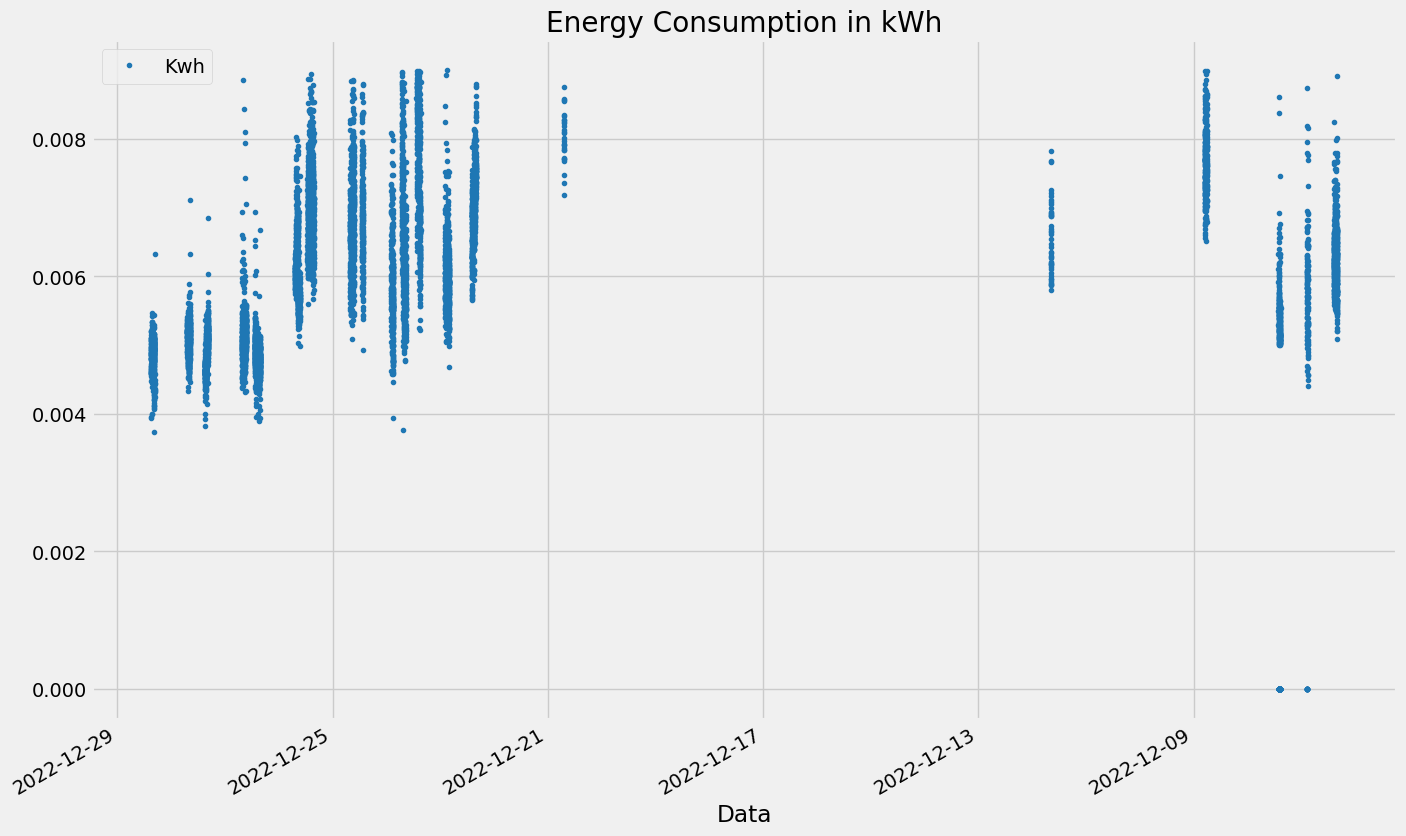

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv('/Users/luciosquitieri/Documents/digital twin/model/Dati.csv')
print(df.head())

df.drop([0,1,2],axis=0,inplace=True)
df.drop("string.2",axis=1,inplace=True)
df.drop("string.3",axis=1,inplace=True)
df.drop("#datatype",axis=1,inplace=True)
df.drop("string",axis=1,inplace=True)
df.drop("long",axis=1,inplace=True)



print(df.head())
#df.drop("true.3",axis=1,inplace=True)
#df.drop("false",axis=1,inplace=True)
#df.drop("false.1",axis=1,inplace=True)
#df.drop("#group",axis=1,inplace=True)

df.rename(columns={'dateTime:RFC3339':'Inizio','dateTime:RFC3339.1':'Fine','dateTime:RFC3339.2':'Data','double':'Kwh','string.1':'Sensore'},inplace=True)



#Valori per XGB
df['Inizio'] = pd.to_datetime(df['Inizio']).dt.strftime("%d-%m-%Y %H:%M:%S")
df['Fine'] = pd.to_datetime(df['Fine'])
df['Fine']=df['Fine'].dt.strftime("%d-%m-%Y %H:%M:%S")
df['Data'] = pd.to_datetime(df['Data'])
df['Data']=df['Data'].dt.strftime("%d-%m-%Y %H:%M:%S")


df=df.set_index('Data')


#Lanciare il comando sopra da solo, eliminare _time e lanciare il secondo comando sotto
df.index=pd.to_datetime(df.index,dayfirst=True)


df['Kwh']=df['Kwh'].astype(float)

df = df[df['Kwh']<0.009]
print(df.head())




df.plot(style='.',
        figsize=(15, 10),
        color=color_pal[0],
        title='Energy Consumption in kWh',
        ).invert_xaxis()


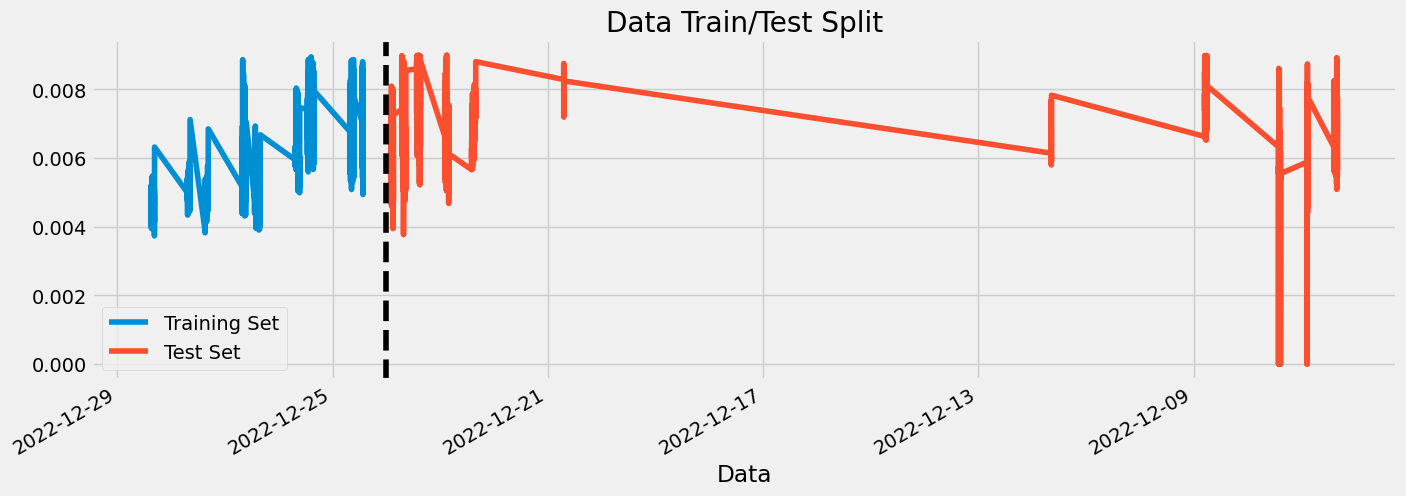

In [4]:
test = df.loc[df.index < '2022-12-24']
train = df.loc[df.index >= '2022-12-24']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set').invert_xaxis()
ax.axvline('2022-12-24', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

In [5]:
# Creazione della feature
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek

    return df


# Feature creation
df = create_features(df)

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek']
TARGET = 'Kwh'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

score: 0.6700164505002821


Text(0.5, 1.0, 'Raw Data and Prediction')

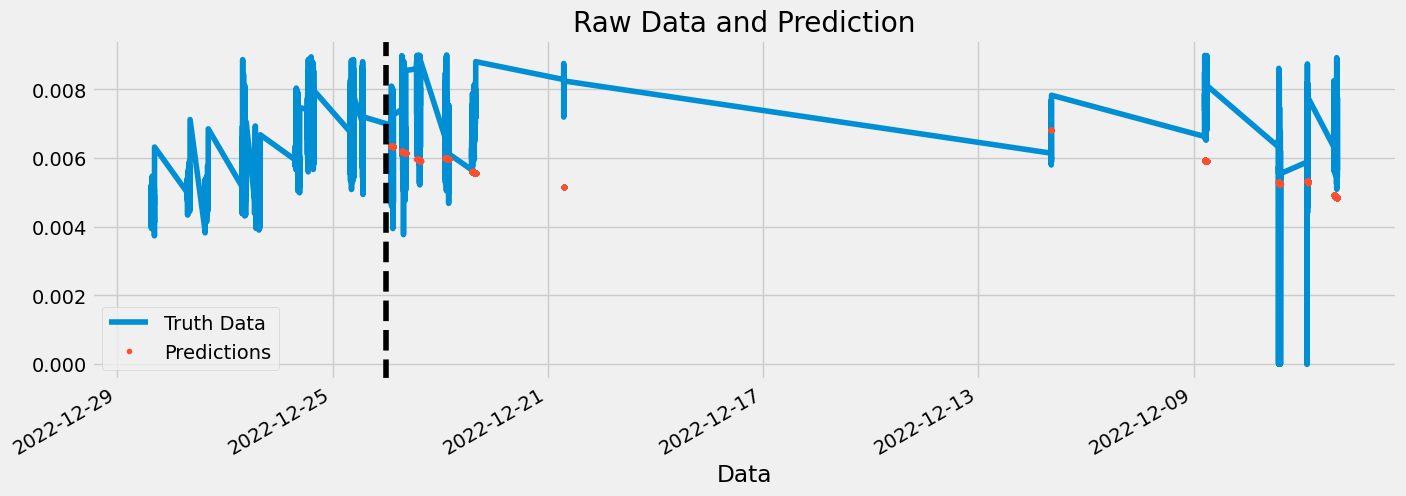

In [6]:
from sklearn.linear_model import SGDRegressor
import requests
import json

r = requests.get(
    "https://ipfs.moralis.io:2053/ipfs/Qmd2iDWBev1VDxmSfTJSGeS1BVh9hqnFnEXe6Dhr4mpDir/modello.json", headers={'Accept': 'application/json'})

data = r.json()

#sgdr = SGDRegressor(loss='squared_error', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, random_state=None, learning_rate='invscaling', eta0=0.01, power_t=0.25, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, warm_start=False, average=False)

sgdr = SGDRegressor(loss=data["loss"], penalty=data["penalty"], alpha=data["alpha"], l1_ratio=data["l1_ratio"], fit_intercept=data["fit_intercept"], max_iter=data["max_iter"], tol=data["tol"], shuffle=data["shuffle"], verbose=data["Verbose"], epsilon=data["epsilon"],
                    random_state= data["random_state"], learning_rate=data["learning_rate"], eta0=data["eta0"], power_t=data["power_t"], early_stopping=data["early_stopping"], validation_fraction=data["validation_fraction"], n_iter_no_change=data["n_iter_no_change"], warm_start=data["warm_start"], average=data["average"])


sgdr.fit(X_train, y_train)

score = sgdr.score(X_train, y_train)
print("score:", score)

# Test del modello realizzato
test['prediction'] = sgdr.predict(X_test)
df = df.merge(test[['prediction']], how='left',
              left_index=True, right_index=True)
ax = df[['Kwh']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.').invert_xaxis()
plt.legend(['Truth Data', 'Predictions'])
ax.axvline('2022-12-24', color='black', ls='--')
ax.set_title('Raw Data and Prediction')
